##  Steel Dynamics Sustainability: Executive Level Benchmarking & Future Strategies

## Stage 5. Revenue - Machine Learning Model Development and Evaluation

This is where the magic happens! Drawing from the problem definition and observations from the previous stage, we will explore a few of the most suitable algorithms (e.g., regression, decision tree, gradient boost) to create models that identify important features and accurately predict performance. This requires dividing the data into training and unseen testing datasets, tuning hyperparameters, and scoring performance. 

In [1]:
#Import all libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.tools.tools as smt
from sklearn.linear_model import LassoCV, LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, classification_report, f1_score
from sklearn.inspection import partial_dependence, PartialDependenceDisplay
import xgboost as xgb  
from xgboost import XGBRegressor
import lightgbm as lgb 
!pip install xgboost
!pip install lightgbm

print("Finished")

Finished


In [2]:
#Convert csv to pandas dataframe 
file_path = "Steel_Stage_5.csv"
df = pd.read_csv(file_path)
print("DataFrame ready")

DataFrame ready


In [3]:
#Define Input Attributes (This is a list of best-performing features in the upcoming Lasso and Random Forest models)
Input_attributes = ['Sustainability_Investments_Million',
'Biodiversity_Specific_Investments_Million',
'R&D_Expenditure_Million',
'Community_Engagement_Spending_Million',                   
'Energy_Consumption_From_Renewables_Percent',             
'Significant_Accidents_Count',                             
'Recycled_Steel_Used_Percent',                                                        
'GHG_Intensity_CO2_Equivalent_Emissions_Per_Ton_Steel']

### Use VIF to determine multicollinearity and Lasso to define the most important features

In [4]:
#Assign Independent and Dependent Variables
X = df[Input_attributes].copy()
y = df['Revenue_Million']

#Standardize the data and use VIF to Check for multicollinearity
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]
print("\nVIF Scores:")
print(vif_data.sort_values('VIF', ascending=False))


VIF Scores:
                                             Feature       VIF
0                 Sustainability_Investments_Million  8.330831
1          Biodiversity_Specific_Investments_Million  7.223573
3              Community_Engagement_Spending_Million  6.268107
4         Energy_Consumption_From_Renewables_Percent  2.261138
2                            R&D_Expenditure_Million  1.588802
6                        Recycled_Steel_Used_Percent  1.446918
5                        Significant_Accidents_Count  1.425094
7  GHG_Intensity_CO2_Equivalent_Emissions_Per_Ton...  1.254059


Note: Significant multicollinearity issues were present in the initial VIF scores (>10) across many ESG attributes. To resolve this and reduce dimensionality, the revised list was developed through an iterative approach using VIF scoring and Lasso scoring (below).

In [5]:
#Lasso Feature Selection: Tune hyperparameters to determine attributes with non-zero coefficients to reduce dimensionality, prevent overfitting, and improve generalization
lasso = LassoCV(cv=5, random_state=0, max_iter=10000).fit(X_scaled, y)
coef_df = pd.Series(lasso.coef_, index=X.columns)

#Select Features
selected_features_with_scores = coef_df[coef_df != 0].sort_values(ascending=False)
selected_features_lasso = selected_features_with_scores.index.tolist()

print("\nLasso Feature Importances:")
print(selected_features_with_scores)


Lasso Feature Importances:
Sustainability_Investments_Million                      2392.400117
Energy_Consumption_From_Renewables_Percent              1359.300392
R&D_Expenditure_Million                                 1130.520404
Recycled_Steel_Used_Percent                              531.549935
Biodiversity_Specific_Investments_Million                508.227563
Significant_Accidents_Count                             -441.736176
GHG_Intensity_CO2_Equivalent_Emissions_Per_Ton_Steel    -991.972158
dtype: float64


Note: Lasso identified sustainability investments, energy consumption from renewables, and R&D spending as the three most influential features.

### Develop a baseline linear regression model using Lasso

In [6]:
#Split into testing and training sets using the selected features
X_train, X_test, y_train, y_test = train_test_split(X[selected_features_lasso], y, test_size=0.2, random_state=42)

#Create Lasso model
lasso = Lasso(random_state=42)

#Define tuning parameters
param_grid_lasso = {
    'alpha': np.logspace(-4, 0, 5)} 

#Set up GridSearchCV for hyperparameter tuning
grid_search_lasso = GridSearchCV(estimator=lasso,
                                 param_grid=param_grid_lasso,
                                 scoring='neg_mean_squared_error',
                                 cv=3,
                                 verbose=2,
                                 n_jobs=-1)

#GridSearchCV to find the best hyperparameters
grid_search_lasso.fit(X_train, y_train)

#Best Lasso model and parameters
best_lasso = grid_search_lasso.best_estimator_
print("Best hyperparameters:", grid_search_lasso.best_params_)

#Make predictions using test data
y_pred_lasso = best_lasso.predict(X_test)

#Evaluate outcomes
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
print(f"Mean Squared Error: {mse_lasso:.2f}")

r2_lasso = r2_score(y_test, y_pred_lasso)
print(f"R-squared: {r2_lasso:.4f}")

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best hyperparameters: {'alpha': 0.0001}
Mean Squared Error: 5689473.56
R-squared: 0.8040


Note: Moving from regression to classification, the Lasso model explained roughly 80% of the variance in revenue. We will now assess its ability to predict whether a company's revenue falls above (High) or below (Low) the industry mean using the selected ESG attributes.


Revenue Classification Report - Lasso:
              precision    recall  f1-score   support

         Low       0.67      0.80      0.73         5
        High       0.83      0.71      0.77         7

    accuracy                           0.75        12
   macro avg       0.75      0.76      0.75        12
weighted avg       0.76      0.75      0.75        12



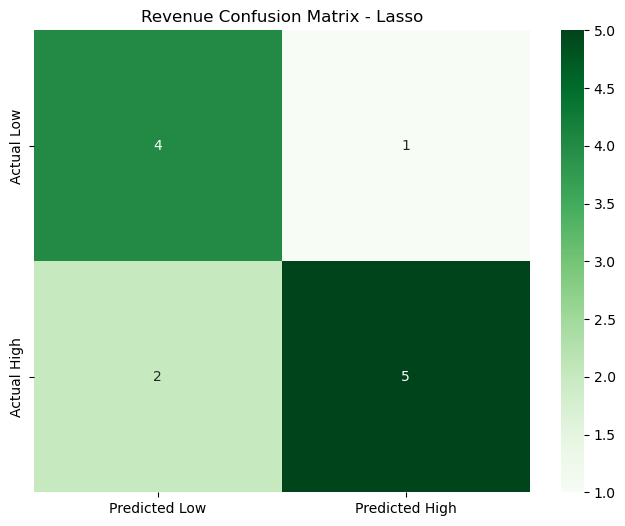

In [7]:
#Convert continuous predictions to categories
threshold = np.mean(y_test)

#Assign values to categorical labels
y_pred_categorical_lasso = ['High' if val > threshold else 'Low' for val in y_pred_lasso]
y_true_categorical = ['High' if val > threshold else 'Low' for val in y_test]

#Classification report
print("\nRevenue Classification Report - Lasso:")
print(classification_report(y_true_categorical, y_pred_categorical_lasso, labels=['Low', 'High']))

#Confusion matrix
cm_lasso = confusion_matrix(y_true_categorical, y_pred_categorical_lasso, labels=['Low', 'High'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_lasso, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Predicted Low', 'Predicted High'],
            yticklabels=['Actual Low', 'Actual High'])
plt.title('Revenue Confusion Matrix - Lasso')
plt.show()

Note: The linear Lasso model accurately predicted whether revenue would be above or below the industry mean in 9 out of 12 cases, based on the assigned important ESG attributes. The F1 score was: 75%.

## Build a non-linear tree based model using Random Forest

In [8]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5],
    'max_features': ['sqrt', 'log2']}

rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best hyperparameters:", grid_search.best_params_)
best_rf = grid_search.best_estimator_

importances = pd.Series(best_rf.feature_importances_, index=selected_features_lasso)
importances = importances.sort_values(ascending=False)
print("\nRandom Forest Feature Importances:")
print(importances)

y_pred_rf = best_rf.predict(X_test) 
mse = mean_squared_error(y_test, y_pred_rf)
r2 = r2_score(y_test, y_pred_rf)

print(f"\nMSE: {mse:.2f}")
print(f"R²: {r2:.4f}")

Fitting 3 folds for each of 162 candidates, totalling 486 fits
Best hyperparameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}

Random Forest Feature Importances:
Sustainability_Investments_Million                      0.298188
Biodiversity_Specific_Investments_Million               0.213124
Energy_Consumption_From_Renewables_Percent              0.154183
R&D_Expenditure_Million                                 0.146612
Recycled_Steel_Used_Percent                             0.069526
Significant_Accidents_Count                             0.065629
GHG_Intensity_CO2_Equivalent_Emissions_Per_Ton_Steel    0.052737
dtype: float64

MSE: 6031110.07
R²: 0.7922


Note: Sustainability investments and energy consumption from renewables were deemed important by both Lasso and Random Forest. But Random Forest identified biodiversity investments as a top feature whereas Lasso chose R&D.


Revenue Classification Report - Random Forest:
              precision    recall  f1-score   support

        High       0.86      0.86      0.86         7
         Low       0.80      0.80      0.80         5

    accuracy                           0.83        12
   macro avg       0.83      0.83      0.83        12
weighted avg       0.83      0.83      0.83        12



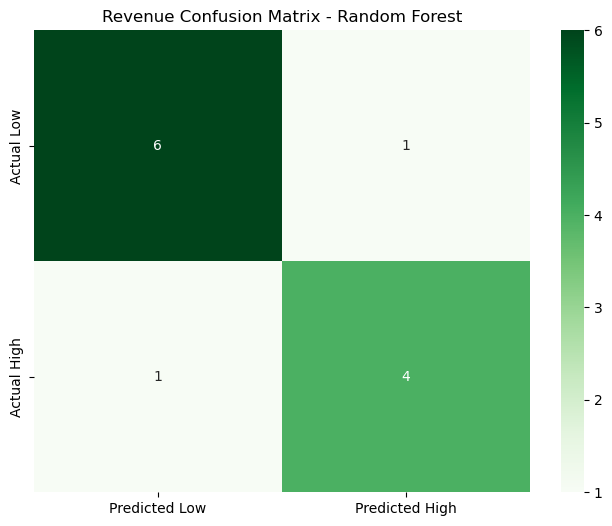

In [9]:
y_pred_category = ['High' if val > y_test.mean() else 'Low' for val in y_pred_rf]
y_test_category = ['High' if val > y_test.mean() else 'Low' for val in y_test]

class_report = classification_report(y_test_category, y_pred_category) 
print("\nRevenue Classification Report - Random Forest:")
print(class_report)

conf_matrix = confusion_matrix(y_test_category, y_pred_category)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['Predicted Low', 'Predicted High'], yticklabels=['Actual Low', 'Actual High'])
plt.title('Revenue Confusion Matrix - Random Forest')
plt.show()

Note: Random Forest predicted 10 out of 12 outcomes correctly, showing an improvement in the F1 score (83% compared to 75% for the linear model).

## Develop a gradient boosting model using XGBoost

XGBoost often surpasses Random Forest in accuracy and generalization due to its ability to learn from errors throughout the process. Its unique feature selection capabilities make it suitable for training on the entire ESG dataset to evaluate its performance. We will develop one XGB model using all features and another using the features identified by Lasso.

In [10]:
#Use all attributes
XGBoost_attributes = ['R&D_Expenditure_Million',
    'Sustainability_Investments_Million',
    'Sustainability_Investments_Per_Employee',
    'Biodiversity_Specific_Investments_Million',
    'Biodiversity_Specific_Investments_Per_Employee',
    'Community_Engagement_Spending_Million',
    'Community_Engagement_Spending_Per_Employee',
    'Total_Energy_Consumption_MWh',
    'Energy_Intensity_kWh_Per_Ton_Steel',
    'Energy_Consumption_From_Renewables_Percent',
    'Recycled_Steel_Used_Percent',
    'Total_Water_Usage_Megaliter',
    'Water_Recycled_Percent',
    'Water_Intensity_Kiloliter_Per_Ton_Steel',
    'Waste_Recycled_Percent',
    'CO2_Emissions_Tonnes',
    'NOx_Emissions_Tonnes',
    'SOx_Emissions_Tonnes',  
    'Total_CO2_Equivalent_Emission_Tonnes',
    'Scope1_CO2_Equivalent_Emissions_Tonnes',
    'Scope2_CO2_Equivalent_Emissions_Tonnes',
    'Scope3_CO2_Equivalent_Emissions_Tonnes',
    'GHG_Intensity_CO2_Equivalent_Emissions_Per_Ton_Steel',
    'Regulation_Noncompliance_Air_And_Water_Incidents',
    'Employee_Turnover_Rate_Percent',
    'Employee_Training_Hours_Per_Employee',
    'Median_Employee_Pay_Nonexecutive',
    'Injury_Rate_Per_100_Employees',
    'Significant_Accidents_Count',
    'Female_Workforce_Percent',
    'Minority_Workforce_Percent',
    'Veteran_Workforce_Percent',
    'Disabled_Workforce_Percent',
    'Community_Volunteer_Hours_Per_Employee',
    'Board_Independence_Percent',
    'Board_Percent_Female',
    'Board_Percent_Minority',
    'Board_Age_Avg',
    'Anti_Corruption_Incidents',
    'Whistleblower_Cases']
X = df[XGBoost_attributes].copy()

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

xgb = XGBRegressor(objective='reg:squarederror',
                    random_state=42,
                    early_stopping_rounds=50)

param_grid_xgb = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [0, 0.01, 0.1]}

grid_search_xgb = GridSearchCV(estimator=xgb,
                                param_grid=param_grid_xgb,
                                scoring='neg_mean_squared_error',
                                cv=3,
                                verbose=2,
                                n_jobs=-1)

grid_search_xgb.fit(X_train_scaled, y_train,
                     eval_set=[(X_test_scaled, y_test)],
                     verbose=False)

best_xgb = grid_search_xgb.best_estimator_
print("\nBest hyperparameters:", grid_search_xgb.best_params_)

y_pred_xgb1 = best_xgb.predict(X_test_scaled)
mse_xgb1 = mean_squared_error(y_test, y_pred_xgb1)
r2_xgb1 = r2_score(y_test, y_pred_xgb1)

feature_importances_xgb = pd.Series(best_xgb.feature_importances_, index=XGBoost_attributes)
feature_importances_xgb = feature_importances_xgb.sort_values(ascending=False)
print("\nXGBoost Feature Importances:")
print(feature_importances_xgb)

print(f"\nMSE: {mse_xgb1:.2f}")
print(f"R²: {r2_xgb1:.4f}")

Fitting 3 folds for each of 8748 candidates, totalling 26244 fits

Best hyperparameters: {'colsample_bytree': 0.7, 'gamma': 0.1, 'learning_rate': 0.03, 'max_depth': 5, 'n_estimators': 500, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'subsample': 0.8}

XGBoost Feature Importances:
Sustainability_Investments_Million                      0.157248
Anti_Corruption_Incidents                               0.117515
Biodiversity_Specific_Investments_Million               0.114397
Sustainability_Investments_Per_Employee                 0.060903
Scope3_CO2_Equivalent_Emissions_Tonnes                  0.058431
Recycled_Steel_Used_Percent                             0.036798
Waste_Recycled_Percent                                  0.034607
Energy_Consumption_From_Renewables_Percent              0.033722
Total_CO2_Equivalent_Emission_Tonnes                    0.032135
Total_Energy_Consumption_MWh                            0.030681
R&D_Expenditure_Million                                 0.027490
GHG_Intensi

Note: XGB determined that sustainability investments, anti corruption incidents, and biodiversity investments were the top features. 83% of revenue variance can be explained by the model.        


Revenue Classification Report - XGB:
              precision    recall  f1-score   support

        High       0.86      0.86      0.86         7
         Low       0.80      0.80      0.80         5

    accuracy                           0.83        12
   macro avg       0.83      0.83      0.83        12
weighted avg       0.83      0.83      0.83        12



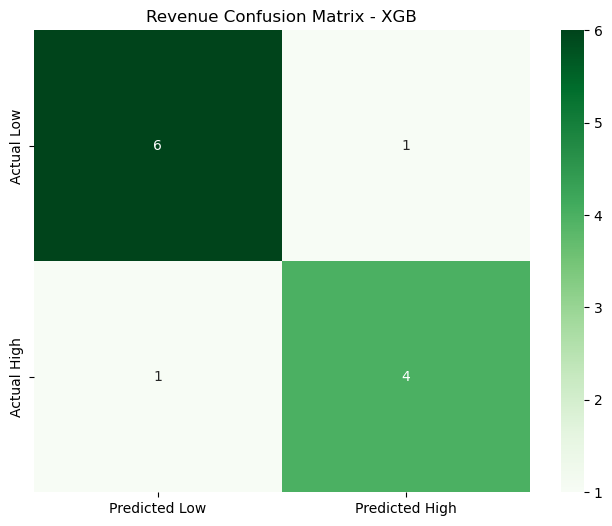

In [12]:
y_pred_category = ['High' if val > y_test.mean() else 'Low' for val in y_pred_xgb1]
y_test_category = ['High' if val > y_test.mean() else 'Low' for val in y_test]

# Classification Report
class_report = classification_report(y_test_category, y_pred_category) 
print("\nRevenue Classification Report - XGB:")
print(class_report)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_category, y_pred_category)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Predicted Low', 'Predicted High'], yticklabels=['Actual Low', 'Actual High'])
plt.title('Revenue Confusion Matrix - XGB')
plt.show()

### For comparison, we will train an XGBoost model using only the features selected by Lasso

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X[selected_features_lasso], y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

xgb = XGBRegressor(objective='reg:squarederror',
                     random_state=42,
                     early_stopping_rounds=50)  

param_grid_xgb = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [0, 0.01, 0.1]
}

grid_search_xgb = GridSearchCV(estimator=xgb,
                               param_grid=param_grid_xgb,
                               scoring='neg_mean_squared_error',
                               cv=3,
                               verbose=2,
                               n_jobs=-1)

grid_search_xgb.fit(X_train_scaled, y_train,
                    eval_set=[(X_test_scaled, y_test)],
                    verbose=False)

best_xgb = grid_search_xgb.best_estimator_
print("\nBest hyperparameters:", grid_search_xgb.best_params_)

y_pred_xgb2 = best_xgb.predict(X_test_scaled)
mse_xgb2 = mean_squared_error(y_test, y_pred_xgb2)
r2_xgb2 = r2_score(y_test, y_pred_xgb2)

feature_importances_xgb = pd.Series(best_xgb.feature_importances_, index=selected_features_lasso)
feature_importances_xgb = feature_importances_xgb.sort_values(ascending=False)
print("\nXGBoost Feature Importances:")
print(feature_importances_xgb)

print(f"\nMSE: {mse_xgb2:.2f}")
print(f"R²: {r2_xgb2:.4f}")

Fitting 3 folds for each of 8748 candidates, totalling 26244 fits

Best hyperparameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.03, 'max_depth': 7, 'n_estimators': 500, 'reg_alpha': 0.01, 'reg_lambda': 0, 'subsample': 0.9}

XGBoost Feature Importances:
Biodiversity_Specific_Investments_Million               0.399868
Sustainability_Investments_Million                      0.158709
R&D_Expenditure_Million                                 0.121757
GHG_Intensity_CO2_Equivalent_Emissions_Per_Ton_Steel    0.118124
Recycled_Steel_Used_Percent                             0.100671
Significant_Accidents_Count                             0.051740
Energy_Consumption_From_Renewables_Percent              0.049131
dtype: float32

MSE: 6421659.08
R²: 0.7788



Revenue Classification Report - XGB (Lasso Features):
              precision    recall  f1-score   support

        High       0.83      0.71      0.77         7
         Low       0.67      0.80      0.73         5

    accuracy                           0.75        12
   macro avg       0.75      0.76      0.75        12
weighted avg       0.76      0.75      0.75        12



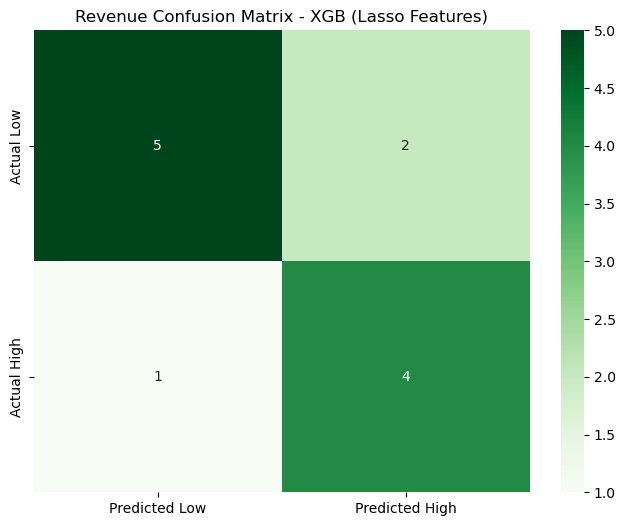

In [14]:
y_pred_category = ['High' if val > y_test.mean() else 'Low' for val in y_pred_xgb2]
y_test_category = ['High' if val > y_test.mean() else 'Low' for val in y_test]

class_report = classification_report(y_test_category, y_pred_category)
print("\nRevenue Classification Report - XGB (Lasso Features):")
print(class_report)

conf_matrix = confusion_matrix(y_test_category, y_pred_category)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Predicted Low', 'Predicted High'], yticklabels=['Actual Low', 'Actual High'])
plt.title('Revenue Confusion Matrix - XGB (Lasso Features)')
plt.show()

Note: In contrast to Lasso and Random Forest, which showed improved performance with reduced dimensionality, XGB performed best when trained on the entire dataset (higher R-squared and F1 score). The drawback of XGB here is its higher resource demands, including processing time.

### Move on to the next target: ESG Score

Note: Both Random Forest and XGBoost yielded the best predictive performance for revenue. XGB's exceptional feature selection capabilities made it the most efficient model. It achieved optimal results in a single iteration, unlike Lasso and Random Forest.

<br>
Author: Kevin Pordon - MBA